# Get data from the BigPEmu Debug Build

In [16]:
import bigpemu_debug as bigp
import struct

"""
Code starts 0x00192000
"""
locations = {
    # The address to start at
    # The number of bytes to fetch
    "LaunchVLM":  (0x00192000, 0x800),
    "avbank":     (0x0019b0c8, 0x80),
    "draw_screen":(0x00148000, 0x4000),
    "dscreen":    (0x00f03f40, 0x8),
    "cscreen":    (0x00f03f44, 0x8),
    "_cscreen":   (0x00148000, 0x4000),
    "_dscreen":   (0x00100000, 0xF000),
    "__cscreen":  (0x00100000, 0x4000),
    "mods":       (0x00f03f48, 0x8),
    "gpumods":    (0x001a69c0, 0x32),
    "curmod":     (0x00f03000, 0x32),
    "beasties":   (0x001ae048, 0x64 * 12),
    "jaglogo":    (0x00199c48, 4492),
    "board":      (0x001b00f8, 0x8),
    "list":       (0x001ae81c, 624),
    "list1":      (0x1AE81C,624),
    "list2":      (0x1AE88C,624),
    "blist":      (0x1AEC7C,8),
    "dlist":      (0x1AEC80,8),
    "ddlist":     (0x1AEC84,8),
}

def send_hex_dump_cmd_raw(from_addr,dump_len):
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)

    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00\x15\x00\x00\x00\x00\x00\x00\x00" \
    + from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,1)
    return response[0][2][24:] # Snip header

def send_hex_dump_cmd(location):
    from_addr,dump_len = locations[location]
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)

    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00\x15\x00\x00\x00\x00\x00\x00\x00" \
    + from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,1)
    return response[0][2][24:] # Snip header

def dump_standard(hex_dump,WIDTH=32):
    mem = '\n'.join([
        ','.join(['{:02X}'.format(x) for x in hex_dump[l:l+WIDTH]]) 
        for l in range(0,len(hex_dump),WIDTH)
    ])
    return mem



## Launch BigPEmu and connect to the debug server

In [33]:
import socket
import os
import time

# Launch bigpemu and wait a moment.
os.system("wine ./BigPEmu_v118-DEV/BigPEmuDev.exe ../src/bin/vlm.abs &")
time.sleep(5)

HOST = "127.0.0.1"  # The server's hostname or IP address
PORT = 44123  # The port used by the server

# Connect to the debug server
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((HOST, PORT))


## Get the Beasties List

In [3]:

def dump_beasties(hex_dump):
    beastie = [
        (0,4,"X"),
        (4,8,"Y"),
        (8,10,"Width"),
        (10,12,"Height"),
        (12,14,"Object Mode"),
        (14,16,"Object Type"),
        (16,20,"Pointer to Screen Data"),
        (20,22,"Post-Creation Routine"),
        (22,24,""),
        (24,26,"Width of Obj from ObTypes"),
        (26,28,"Height of Obj from ObTypes"),
        (28,30,"Depth of Obj from ObTypes"),
        (30,32," "),
        (32,64,"Remainder"),
    ]
    result = []
    for i in range(0,12):
        offset = i * 64
        result += [f"\nBeastie {i}"]
        for s,e,d in beastie:
            start = offset + s
            end = offset + e
            bs = ','.join(['{:02X}'.format(x) for x in hex_dump[start:end]]) 
            result += [f"Byte {s}-{e}: {d}: {bs}"]
    return '\n'.join(result)
    

hex_dump = send_hex_dump_cmd("beasties")
print(dump_beasties(hex_dump))



Beastie 0
Byte 0-4: X: FF,F8,00,00
Byte 4-8: Y: FF,7C,00,00
Byte 8-10: Width: 00,3A
Byte 10-12: Height: 00,14
Byte 12-14: Object Mode: 00,00
Byte 14-16: Object Type: 00,03
Byte 16-20: Pointer to Screen Data: 00,14,80,00
Byte 20-22: Post-Creation Routine: FF,FF
Byte 22-24: : 00,00
Byte 24-26: Width of Obj from ObTypes: 00,60
Byte 26-28: Height of Obj from ObTypes: 01,80
Byte 28-30: Depth of Obj from ObTypes: 00,04
Byte 30-32:  : 00,00
Byte 32-64: Remainder: 00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00

Beastie 1
Byte 0-4: X: 00,00,00,00
Byte 4-8: Y: 00,00,00,00
Byte 8-10: Width: 00,00
Byte 10-12: Height: 00,00
Byte 12-14: Object Mode: FF,FF
Byte 14-16: Object Type: 00,00
Byte 16-20: Pointer to Screen Data: 00,00,00,00
Byte 20-22: Post-Creation Routine: 00,00
Byte 22-24: : 00,00
Byte 24-26: Width of Obj from ObTypes: 00,00
Byte 26-28: Height of Obj from ObTypes: 00,00
Byte 28-30: Depth of Obj from ObTypes: 00,00
Byte 30-32:  : 00,00
Byt

## Get the Object List

In [6]:
obj_names = [
    "Bit Mapped Object",
    "Scaled Bit Mapped Object",
    "Graphics Processor Object",
    "Branch Object",
    "Stop Object",
    "Unused",
    "Unused",
    "Unused RAM",
]

obj_defs = {
    0: [ # Bit Mapped Object
            [ # First Phrase
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,23,"HEIGHT"),
                (24,42,"LINK"),
                (43,63,"DATA"),
            ],
            [ # Second Phrase
                (0,11,"XPOS"),
                (12,14,"DEPTH"),
                (15,17,"PITCH"),
                (18,27,"DWIDTH"),
                (28,37,"IWIDTH"),
                (38,44,"INDEX"),
                (45,45,"REFLECT"),
                (46,46,"RMW"),
                (47,47,"TRANS"),
                (48,48,"RELEASE"),
                (49,54,"FIRSTPIX"),
            ],
    ],
    1: [ #Scaled Bit Mapped Object
            [ # First Phrase
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,23,"HEIGHT"),
                (24,42,"LINK"),
                (43,63,"DATA"),
            ],
            [ # Second Phrase
                (0,11,"XPOS"),
                (12,14,"DEPTH"),
                (15,17,"PITCH"),
                (18,27,"DWIDTH"),
                (28,37,"IWIDTH"),
                (38,44,"INDEX"),
                (45,45,"REFLECT"),
                (46,46,"RMW"),
                (47,47,"TRANS"),
                (48,48,"RELEASE"),
                (49,54,"FIRSTPIX"),
            ],
            [ # Third Phrase
                (0,7, "HSCALE"),
                (8,15,"VSCALE"),
                (16,23,"REMAINDER"),
            ],
    ],
    2: [ # Graphics Processor Object
            [
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,63,"DATA"),
            ],
    ],
    3: [ # Branch Object
            [
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,15,"CC"),
                (16,23,"Unused"),
                (24,42,"LINK"),
            ],
    ],
    4: [ # Stop Object
            [
                (0,2,"Type"),
                (3,63,"DATA"),
            ],
    ],
    7: [ # Unused RAM
            [
                (0,2,"Type"),
                (3,63,"Unused RAM"),
            ],
    ],
}

In [34]:
hex_dump = send_hex_dump_cmd("ddlist")
print(dump_standard(hex_dump))


00,1A,E8,10,FF,FF,FF,FF


In [35]:
hex_dump = send_hex_dump_cmd_raw(0x001ae810,624)
obj_list_raw = dump_standard(hex_dump,WIDTH=8)


In [36]:
# Extract the bits for each entry in the object.
get_bits = lambda o,start,end: (o >> start) & int('1' * ((end-start)+1),base=2)
def get_type(o): return get_bits(o,0,2)

obj_list = obj_list_raw.split("\n")[1:-1]
i = 0
while True:
    if i >= len(obj_list):
        break
    o = int(obj_list[i].replace(',',''),16)
    o_type = get_type(o)
    if o_type == 7:
        break
    assert(o_type in obj_defs)
    o_vals = []
    print(obj_names[o_type])
    for o_map in obj_defs[o_type]:
        o = int(obj_list[i].replace(',',''),16)
        for start,end,description in o_map:
            o_val = get_bits(o,start,end)
            if description in ["DATA","LINK"]:
                o_val = hex(o_val << 3)
            o_vals += [f"{description}: {o_val}"]
        i+=1
    print('    ' + '\n    '.join(o_vals))

Branch Object
    Type: 3
    YPOS: 507
    CC: 2
    Unused: 0
    LINK: 0x1ae800
Scaled Bit Mapped Object
    Type: 1
    YPOS: 0
    HEIGHT: 192
    LINK: 0x1ae840
    DATA: 0x14e300
    XPOS: 4088
    DEPTH: 4
    PITCH: 1
    DWIDTH: 96
    IWIDTH: 24
    INDEX: 0
    REFLECT: 0
    RMW: 0
    TRANS: 0
    RELEASE: 0
    FIRSTPIX: 0
    HSCALE: 64
    VSCALE: 64
    REMAINDER: 1
Stop Object
    Type: 4
    DATA: 0x0
Bit Mapped Object
    Type: 0
    YPOS: 0
    HEIGHT: 384
    LINK: 0x1ae860
    DATA: 0x192000
    XPOS: 384
    DEPTH: 3
    PITCH: 1
    DWIDTH: 1
    IWIDTH: 1
    INDEX: 4
    REFLECT: 0
    RMW: 0
    TRANS: 0
    RELEASE: 1
    FIRSTPIX: 0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Scaled Bit Mapped Object
    Type: 1
    YPOS: 0
    HEIGHT: 192
    LINK: 0x1ae880
    DATA: 0x14e3c0
    XPOS: 184
    DEPTH: 4
    PITCH: 1
    DWIDTH: 96
    IWIDTH: 24
    INDEX: 0
    REFLECT: 0
    RMW: 0
    TRANS: 0
    RELEASE: 0
    FIRSTPIX

In [38]:
hex_dump = send_hex_dump_cmd_raw(0x14e300,0xF000)
print(dump_standard(hex_dump,WIDTH=32))


77,00,77,00,77,00,77,00,E8,00,E8,00,E8,00,E8,00,F9,00,F9,00,F9,00,F9,00,F9,00,F9,00,F9,00,F9,00
F9,00,F9,00,F9,00,F9,00,F9,00,F9,00,F9,00,F9,00,FA,00,FA,00,FA,00,FA,00,FA,00,FA,00,EA,00,EA,00
EA,00,EA,00,EA,00,EA,00,EB,00,EB,00,EB,00,DB,01,DB,01,DB,03,DB,03,CC,06,CC,06,CC,06,CC,06,CC,06
CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06
CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,06,CC,08,CC,0A,BC,0C,BD,0E,BD,10,AD,12,AD,15,AE,17
9E,19,9E,1B,8E,1D,8F,1F,8F,21,7F,24,7F,25,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23
7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23,7F,23
7F,23,7F,23,7F,23,7F,23,6F,21,6F,21,6F,1F,6F,1F,5E,1D,5E,1D,5E,1D,5E,1B,5E,1B,5E,1B,5E,18,5E,18
5E,18,4E,16,4E,16,4E,16,4D,14,4D,14,4D,14,4D,12,4D,12,4D,12,4D,12,3D,10,3D,10,3D,10,3D,10,3D,0E
3D,0E,3D,0E,3D,0E,3C,0C,3C,0C,3C,0C,3C,0C,2C,09,2C,09,2C,09,2C,09,2C,09,2C,07,2C,07,2C,07,2C,07
2C,07,1B,05,1B,05,1B,05,1B,05,1B,05,1B,0

In [32]:
hex((96*8) * 192)

'0x24000'

In [ ]:
"""
Scaled Bit Mapped Object
    Type: 1
    YPOS: 0
    HEIGHT: 192
    LINK: 0x1ae880
    DATA: 0x14e3c0
    XPOS: 184
    DEPTH: 4
    PITCH: 1
    DWIDTH: 96
    IWIDTH: 24
    INDEX: 0
    REFLECT: 0
    RMW: 0
    TRANS: 0
    RELEASE: 0
    FIRSTPIX: 0
    HSCALE: 64
    VSCALE: 64
    REMAINDER: 1
"""

In [42]:
import cry_rgb as cry
from PIL import Image, ImageColor
import numpy as np

def getPixels(cry_pixels,width=2):
    rgb_pixels = []
    for i in range(0, len(cry_pixels),2):
        t = cry_pixels[i:i+2]
        #print(i,t,int.from_bytes(t,'little'))
        rgb = cry.cry_to_rgb(int.from_bytes(t,'big'))
        rgb_pixels += [rgb]
    pad_len = width - (len(rgb_pixels) % width)
    rgb_pixels += [(0,0,0)] * pad_len # Pad to our chosen width
    pixels = np.array(rgb_pixels).astype(np.uint8)
    pixels.shape = (-1,width,3)
    return pixels

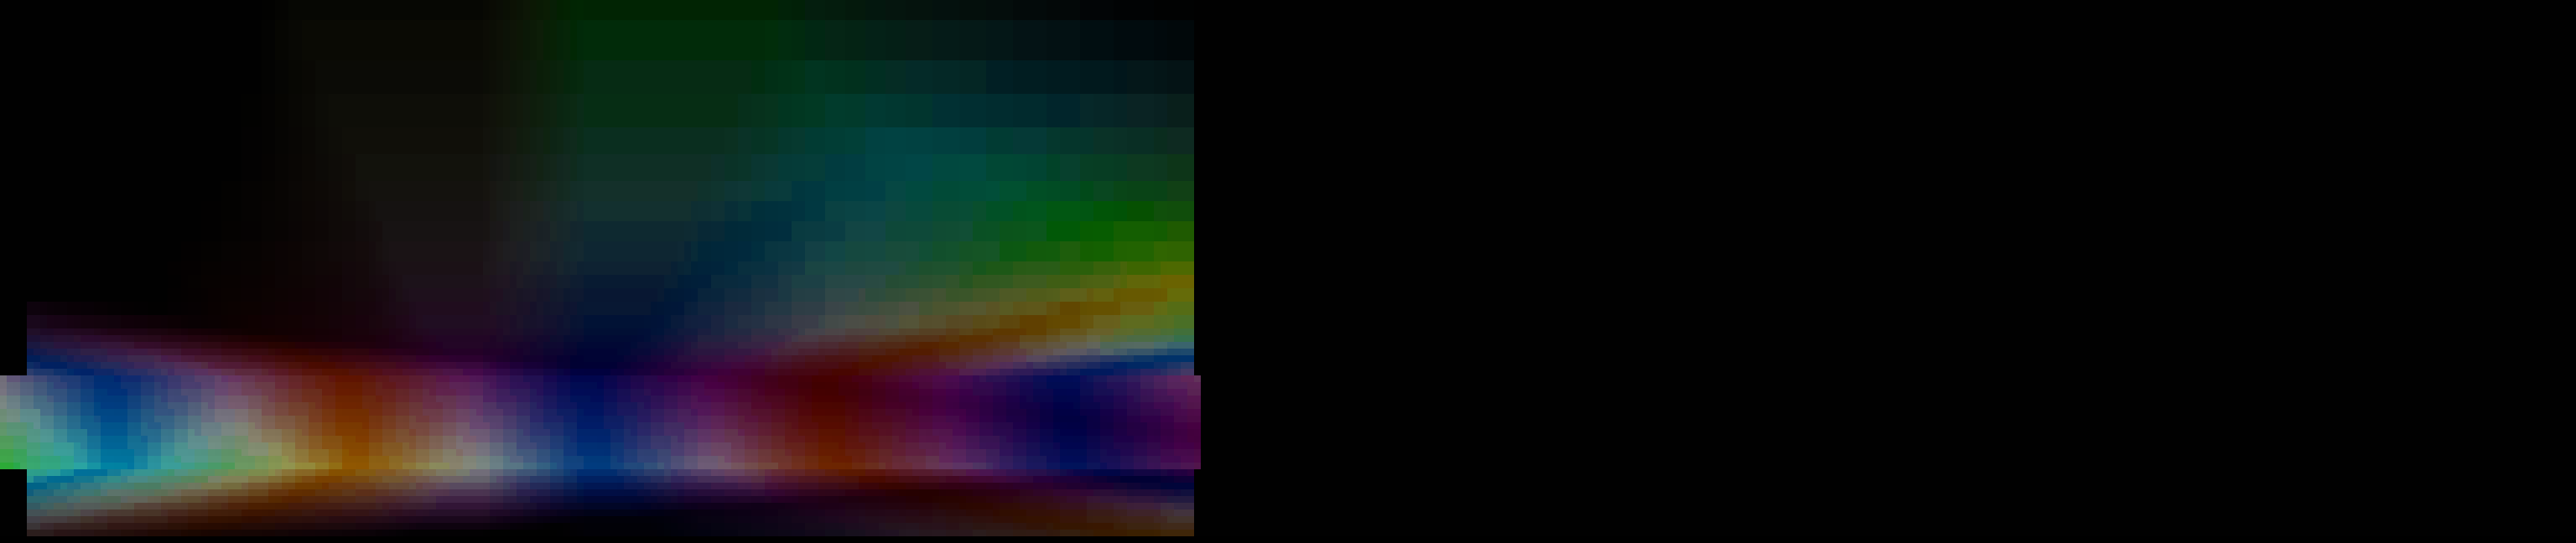

In [41]:
width = 384
scale = 8

pixels = getPixels(hex_dump,width)

img = Image.fromarray(pixels,mode='RGB')
img = img.resize((img.width * scale, img.height * scale), Image.NEAREST)
img

# Rough Work

In [320]:
hex_dump = send_hex_dump_cmd("jaglogo")
print(dump_standard(hex_dump))

00,00,00,00,00,00,00,00,00,00,1F,F8,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00
00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,0F,FF,F8,00,00,00,00,00,00,00,00,00,00,00,00
00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,01,FF,FF,F0,00,00,00,00
00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00
3F,FF,FF,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00
00,00,00,00,00,00,00,07,FF,FF,C0,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00
00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,FF,FF,FF,E0,00,00,00,00,00,00,00,00,00,00,00,00,00
00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,1F,FF,FF,FF,E0,00,00,00,00,00
00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,07,FF,FF
FF,FF,C0,00,00,00,00,00,00,00,00,30,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00
00,00,00,00,07,FF,FF,FF,FF,FF,80,00,00,0

## Get some basic system info

In [228]:
hello  = b"\x01\x00\x00\x00\x08\x00\x00\x00\x14\x00\x00\x00" \
         b"\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00"

s.sendall(hello)
response = get_response(s,5)
print(response)


BrokenPipeError: [Errno 32] Broken pipe

## Get a disassembly

In [206]:
hello3 = b"\x0f\x00\x00\x00\x18\x00\x00\x00\x20\x00\x00\x00\x00\x00\x00\x00" \
b"\x6c\x36\xf0\x00\x00\x00\x00\x00\x6c\x36\xf0\x00\x00\x00\x00\x00" \
b"\xc2\x00\x00\x00\x00\x00\x00\x00"

s.sendall(hello3)
response = get_response(s,1)
#print(len(response),response)


In [323]:
0x60 * 4

384

## Get a memory hex dump

In [291]:
l = (0x64 * 12)
dump_len = struct.pack('<I', l)
print(dump_len)


b'\xb0\x04\x00\x00'
